In [1]:
import sys
 
# setting path
sys.path.append('../../real_estate_price_prediction')

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from joblib import dump
import pickle
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error, r2_score, PredictionErrorDisplay
import copy

from utils import counties_transformer
from utils import column_transformer
from utils import pos_processing

# Dataset

## Data Import

In [3]:
df = pd.read_pickle('../data/df_input.pkl')

## Data Filter

In [4]:
# There are extreme outliers in both tails
q = 0.975

In [5]:
df.price.quantile(q)

395000.0

In [6]:
df.price.quantile(1-q)

38900.0

In [7]:
df = df[(df.price < df.price.quantile(0.975)) & (df.price > df.price.quantile(0.025))]

In [8]:
df.price.describe()

count     28226.000000
mean     110025.620775
std       61662.664781
min       38901.000000
25%       68500.000000
50%       90000.000000
75%      130000.000000
max      393000.000000
Name: price, dtype: float64

In [9]:
df = df[df.suprafata_teren <= 2500.0]

In [10]:
df.reset_index(drop = True, inplace=True)

In [11]:
df = df.loc[:, ['property_type', 'county', 'zona', 'suprafata_utila', 'suprafata_teren', 'posibilitate_parcare', 'nr_locuri_parcare', 'numar_camere', 'numar_bai', 'an_finalizare_constructie', 'price']]

# Train Test Split

In [12]:
X = df.drop('price', axis = 1)
y = df.price

In [13]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=123, 
    stratify=X.county.values
)

In [14]:
y_train.describe()

count     22381.000000
mean     109815.799651
std       61268.499962
min       38901.000000
25%       68500.000000
50%       90000.000000
75%      130000.000000
max      393000.000000
Name: price, dtype: float64

In [15]:
y_test.describe()

count      5596.000000
mean     109638.923159
std       61781.975949
min       38999.000000
25%       68000.000000
50%       89800.000000
75%      130000.000000
max      392000.000000
Name: price, dtype: float64

# Feature Engineering

In [16]:
# Import necessary modules
#from sklearn_pandas import DataFrameMappera

# Check number of nulls in each feature columna
nulls_per_column = X_train.isnull().sum()
print(nulls_per_column)

# Create a boolean mask for categorical columns
categorical_feature_mask = X_train.dtypes == object

# Get list of categorical column names
categorical_columns = X_train.columns[categorical_feature_mask].tolist()

# Get list of non-categorical column names
non_categorical_columns = X_train.columns[~categorical_feature_mask].tolist()

property_type                    0
county                           0
zona                             2
suprafata_utila                  0
suprafata_teren                  0
posibilitate_parcare         12566
nr_locuri_parcare                0
numar_camere                     0
numar_bai                     4212
an_finalizare_constructie     1429
dtype: int64


In [17]:

num_pipe = make_pipeline(
    SimpleImputer(strategy="median")
)
num_pipe.set_output(transform = 'pandas')

cat_pipe = make_pipeline(
    SimpleImputer(strategy = "constant", fill_value='missing'), 
    OneHotEncoder(sparse_output=False, drop='if_binary')
)
cat_pipe.set_output(transform = 'pandas')

numeric_categorical_transformer = make_column_transformer(
    (num_pipe, non_categorical_columns),
    (cat_pipe, categorical_columns),
    verbose_feature_names_out = False
)
numeric_categorical_transformer.set_output(transform = 'pandas')

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['suprafata_utila', 'suprafata_teren',
                                  'nr_locuri_parcare', 'numar_camere',
                                  'numar_bai', 'an_finalizare_constructie']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False))]),
                                 ['property_type', 'county', 'zona',
                                  'posibilitate_parcare'])],
                  verbose_feature_names_out=False)

In [18]:
type(column_transformer)

sklearn.compose._column_transformer.ColumnTransformer

In [19]:
#  Both column_transformer and pos_processing are ColumnTransformer objects.
#  They are defined in the utils.py module because it is necessary to reference them when loading them in the application with picle.load()

transformation_pipe = Pipeline(
    [
        ("columns_transformers", column_transformer),
        ("feature_transformer", numeric_categorical_transformer),
        ("area", pos_processing) 
    ]
)


In [20]:
#  Save only the transfomation pipe
pickle.dump(transformation_pipe, open('../models/ml/transformation_pipe.pkl', 'wb'))

# Modeling Baseline

## Baseline regression

In [21]:
# Are the transformation steps working?
X_train_transformed = transformation_pipe.fit_transform(X_train)

In [22]:
X_test_transformed = transformation_pipe.transform(X_test)

In [23]:
num_pipe = make_pipeline(
    SimpleImputer(strategy="median")
)
num_pipe.set_output(transform = 'pandas')

cat_pipe = make_pipeline(
    SimpleImputer(strategy = "constant", fill_value='missing'), 
    OneHotEncoder(sparse_output=False, drop='first') # the main change is first, which is essential especially for OLS
)
cat_pipe.set_output(transform = 'pandas')

numeric_categorical_transformer = make_column_transformer(
    (num_pipe, non_categorical_columns),
    (cat_pipe, categorical_columns),
    verbose_feature_names_out = False
)
numeric_categorical_transformer.set_output(transform = 'pandas')

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['suprafata_utila', 'suprafata_teren',
                                  'nr_locuri_parcare', 'numar_camere',
                                  'numar_bai', 'an_finalizare_constructie']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['property_type', 'county', 'zona',
                                  'posibilitate_parcare'])],
                  verbose_feature_names_out=False)

In [24]:
ridge_reg_transformation_pipe = Pipeline(
    [
        ("column", column_transformer),
        ("feature_transformer", numeric_categorical_transformer),
        ("area", pos_processing)
    ]
)
ridge_reg_transformation_pipe.set_output(transform = 'pandas')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


Pipeline(steps=[('column',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('functiontransformer-1',
                                                  FunctionTransformer(func=<function select_counties at 0x11d2fca40>),
                                                  ['county']),
                                                 ('functiontransformer-2',
                                                  FunctionTransformer(func=<function is_central at 0x11d388220>),
                                                  ['zona'])],
                                   verbose_feature_names_out=False)),
                ('feature_transformer',
                 ColumnTransfo...
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['property_type', 'county',
                                                   'zona',
                                                   'posibilitate_parcare'])],
                                   verbose_feature_names_out=False)),
                ('area',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('functiontransformer',
                                                  FunctionTransformer(func=<function fe_area_ratio at 0x11d3884a0>),
                                                  ['suprafata_utila',
                                                   'suprafata_teren'])],
                                   verbose_feature_names_out=False))])

In [25]:
X_train_transformed = ridge_reg_transformation_pipe.fit_transform(X_train)

In [26]:
from sklearn.linear_model import RidgeCV
# Define a range of alpha values to try
alphas = np.arange(0.1, 10, 0.1)

# Create RidgeCV with the alpha values
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)

# Perform cross-validation
cross_val_scores = cross_val_score(ridge_cv, X_train_transformed, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')

ridge_cv.fit(X_train_transformed, y_train)

# Access the best alpha

best_alpha = ridge_cv.alpha_

This is the baseline MAPE:

In [27]:
cross_val_scores.mean()

-0.2614832333567649

### Baseline XGBoost

In [ ]:
# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(
    n_estimators = 10,
    seed = 123,
    objective = 'reg:squarederror',
    booster="gbtree"
)

# Fit the regressor to the training set
xg_reg.fit(X_train_transformed, y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test_transformed)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
mape = mean_absolute_percentage_error(y_test, preds)
print("MAPE: {mape}".format(mape = mape))

msle = mean_squared_log_error(y_test, preds)
print("MSLE: {msle}".format(msle = msle))

In [ ]:
# Convert the training and testing sets into DMatrixes: DM_train, DM_test
DM_train = xgb.DMatrix(data = X_train_transformed, label = y_train)
DM_test =  xgb.DMatrix(data = X_test_transformed, label = y_test)

In [ ]:
DM_train.feature_names

In [ ]:
# Create the DMatrix: housing_dmatrix
#housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":5}

# Perform cross-validation: cv_results
cv_results = xgb.cv(
    dtrain=DM_train, 
    params=params, 
    nfold=4, 
    num_boost_round=1000,
    early_stopping_rounds = 10, #Early stop prevents overfitting
    metrics="mape", 
    as_pandas=True, 
    seed=123)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results["test-mape-mean"]).tail(1))

# TODO: Add % variation from one round compared to the previous

cv_results.loc[:, ["train-mape-mean", "test-mape-mean"]].plot()

In [ ]:
# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()

# Modeling 

## XGBosst Random Search

In [ ]:
# Makes a copy of the transformation pipeline
xgb_pipeline = copy.deepcopy(transformation_pipe)

# Appends estimator
xgb_pipeline.steps.append(["xgb_reg", xgb.XGBRegressor(booster="gbtree", seed = 123)])

# Create the parameter grid
gbm_param_grid = {
    'xgb_reg__learning_rate': np.arange(0.01, 0.5, 0.025),
    'xgb_reg__max_depth': range(3, 11, 2),
    'xgb_reg__n_estimators': range(5, 205, 10),
    #'xgb_reg__colsample_bytree': np.arange(0.25, 1.25, 0.25),
    'xgb_reg__lambda': np.arange(0.05, 1, 0.05),
    'xgb_reg__subsample': np.arange(0.5, 1, 0.1)
}

In [ ]:
# Number of folds
nr_of_folds = 2

# Total number of fits if all combinations are fitted
np.prod([len(v) for v in gbm_param_grid.values()]) * nr_of_folds

In [ ]:

# Perform RandomizedSearchCV
randomized_mape= RandomizedSearchCV(
    estimator = xgb_pipeline, 
    param_distributions = gbm_param_grid,
    n_iter = 300,
    cv = nr_of_folds,
    scoring = "neg_mean_absolute_percentage_error",
    verbose = 1
)

# Fit the estimator
randomized_mape.fit(X_train, y_train)

In [ ]:
pd.DataFrame(randomized_mape.cv_results_).sort_values('mean_test_score')

In [ ]:
# Compute metrics
print(randomized_mape.best_score_)
print(randomized_mape.best_estimator_)

In [ ]:
best_parms = dict(zip([i.split('__')[1] for i in randomized_mape.best_params_.keys()], randomized_mape.best_params_.values()))

In [ ]:
params = best_parms.copy()

In [ ]:
params["objective"] = "reg:squarederror"

In [ ]:
params.pop('n_estimators')

In [ ]:
best_parms

In [ ]:
params

In [ ]:
# Create the DMatrix: housing_dmatrix
#housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
#params = {"objective":"reg:squarederror", "max_depth":5}

# Perform cross-validation: cv_results
cv_results = xgb.cv(
    dtrain=DM_train, 
    params=params, 
    nfold=5, 
    num_boost_round=100,
    early_stopping_rounds = 2, #Early stop prevents overfitting
    metrics="mape", 
    as_pandas=True, 
    seed=123)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results["test-mape-mean"]).tail(1))

# TODO: Add % variation from one round compared to the previous

cv_results.loc[:, ["train-mape-mean", "test-mape-mean"]].plot()

In [ ]:
best_parms

In [ ]:
best_parms['n_estimators'] = cv_results.shape[0]

### Final Model

In [28]:
#best_parms = pickle.load(open('../models/ml/best_parms.pkl', 'rb'))
#print(best_parms)
best_parms = pickle.load(open('../models/ml/xgb_best_parms.pkl', 'rb'))
print(best_parms)

{'subsample': 0.7, 'n_estimators': 70, 'max_depth': 9, 'learning_rate': 0.035, 'lambda': 0.4}


In [29]:
xgb_reg_model = Pipeline(
    [
        ("columns_transformers", column_transformer),
        ("feature_transformer", numeric_categorical_transformer),
        ("area", pos_processing),
        ("xgb_reg", xgb.XGBRegressor(booster="gbtree", **best_parms))
    ]
)

In [30]:
xgb_reg_model.fit(X_train, y_train)

Pipeline(steps=[('columns_transformers',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('functiontransformer-1',
                                                  FunctionTransformer(func=<function select_counties at 0x11d2fca40>),
                                                  ['county']),
                                                 ('functiontransformer-2',
                                                  FunctionTransformer(func=<function is_central at 0x11d388220>),
                                                  ['zona'])],
                                   verbose_feature_names_out=False)),
                ('feature_transformer'...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, lambda=0.4,
                              learning_rate=0.035, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=9, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=70,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, ...))])

In [31]:
y_test_pred = xgb_reg_model.predict(X_test)

### Save model

In [ ]:
pickle.dump(xgb_reg_model, open('../models/ml/xgb_reg_model.pkl', 'wb'))

In [32]:
y_train_pred = xgb_reg_model.predict(X_train)
y_test_pred = xgb_reg_model.predict(X_test)

## Model Diagnosis

Deciles
1     0.185238
2     0.150772
3     0.143170
4     0.129833
5     0.150887
6     0.159626
7     0.177199
8     0.171511
9     0.181793
10    0.233738
dtype: float64


<Axes: title={'center': 'MAPE by Decile in Training'}, xlabel='Deciles', ylabel='MAPE'>

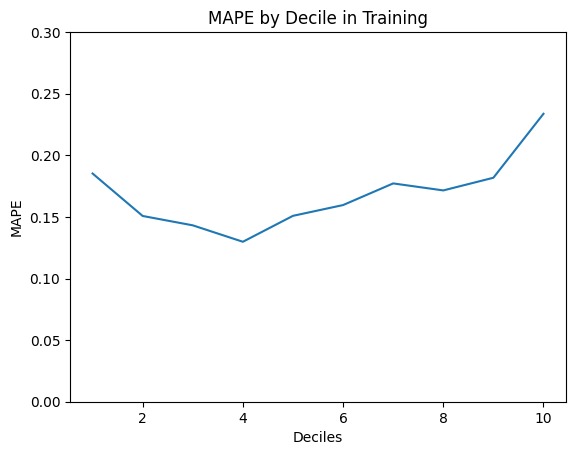

In [33]:
train_results = pd.DataFrame(zip(y_train, y_train_pred), columns=['y_train', 'y_train_pred'])


cut_points = list(train_results.y_train.quantile(np.arange(0,1,0.1)))

cut_points.append(np.Inf)

cut_points.insert(0, -np.Inf)

cut_points = list(set(cut_points))

cut_points.sort()

train_results['Deciles'] = pd.cut(train_results.y_train,cut_points, right=False, ordered=True, labels = False)

mape_deciles = train_results.groupby('Deciles').apply(lambda group: mean_absolute_percentage_error(group['y_train'], group['y_train_pred'])).sort_index()

#print(mape_deciles)

#mean_absolute_percentage_error(
#    train_results.loc[train_results.Deciles.isin(range(0,6)), 'y_train'],
#    train_results.loc[train_results.Deciles.isin(range(0,6)), 'y_train_pred'])

mape_deciles.plot(ylabel = 'MAPE', title = 'MAPE by Decile in Training', ylim = [0,0.3])

### Test Diagnosis

<Axes: title={'center': 'MAPE by Decile in Test set'}, xlabel='Deciles', ylabel='MAPE'>

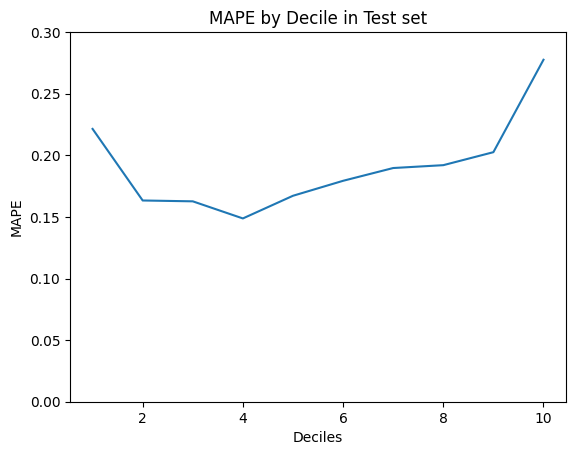

In [36]:
test_results = pd.DataFrame(zip(y_test, y_test_pred), columns=['y_test', 'y_test_pred'])

cut_points = list(test_results.y_test.quantile(np.arange(0,1,0.1)))

cut_points.append(np.Inf)

cut_points.insert(0, -np.Inf)

cut_points = list(set(cut_points))

cut_points.sort()

test_results['Deciles'] = pd.cut(test_results.y_test,cut_points, right=False, ordered=True, labels = False)

mape_deciles = test_results.groupby('Deciles').apply(lambda group: mean_absolute_percentage_error(group['y_test'], group['y_test_pred'])).sort_index()

#print(mape_deciles)

#mean_absolute_percentage_error(
#    train_results.loc[train_results.Deciles.isin(range(0,6)), 'y_train'],
#    train_results.loc[train_results.Deciles.isin(range(0,6)), 'y_train_pred'])

mape_deciles.plot(ylabel = 'MAPE', title = 'MAPE by Decile in Test set', ylim = [0,0.3])

In [49]:
test_results['Deciles_interval'] = pd.cut(test_results.y_test,cut_points, right=False, ordered=True).astype('str')

In [50]:
test_results.groupby(['Deciles', 'Deciles_interval']).apply(lambda group: mean_absolute_percentage_error(group['y_test'], group['y_test_pred']))

Deciles  Deciles_interval    
1        [38999.0, 55000.0)      0.221452
2        [55000.0, 64500.0)      0.163341
3        [64500.0, 72000.0)      0.162654
4        [72000.0, 80000.0)      0.148769
5        [80000.0, 89800.0)      0.167169
6        [89800.0, 103500.0)     0.179316
7        [103500.0, 120000.0)    0.189686
8        [120000.0, 145000.0)    0.192007
9        [145000.0, 189450.0)    0.202548
10       [189450.0, inf)         0.277574
dtype: float64

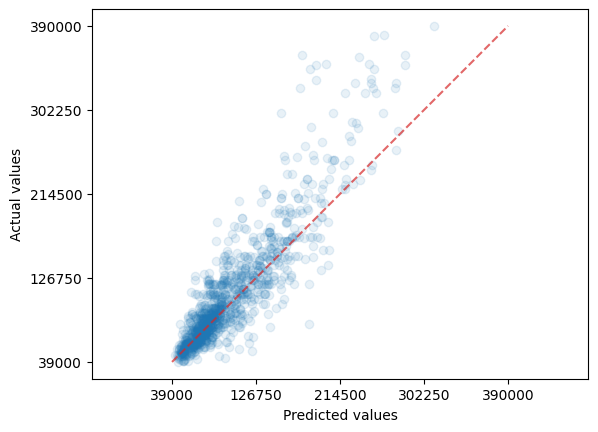

In [60]:
PredictionErrorDisplay.from_predictions(
        y_true=train_results.y_train,
        y_pred=train_results.y_train_pred,
        kind="actual_vs_predicted",
        #ax=ax,
        scatter_kwargs={"alpha": 0.1, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )

In [67]:
test_results

,y_test,y_test_pred,Deciles,Deciles_interval
0,348000.0,271179.500000,10,"[189450.0, inf)"
1,110000.0,159050.531250,7,"[103500.0, 120000.0)"
2,60000.0,77696.109375,2,"[55000.0, 64500.0)"
3,84000.0,77681.703125,5,"[80000.0, 89800.0)"
4,159000.0,158638.937500,9,"[145000.0, 189450.0)"
...,...,...,...,...
5591,85000.0,66453.015625,5,"[80000.0, 89800.0)"
5592,74400.0,64837.925781,4,"[72000.0, 80000.0)"
5593,59500.0,60363.179688,2,"[55000.0, 64500.0)"
5594,45000.0,68335.382812,1,"[38999.0, 55000.0)"


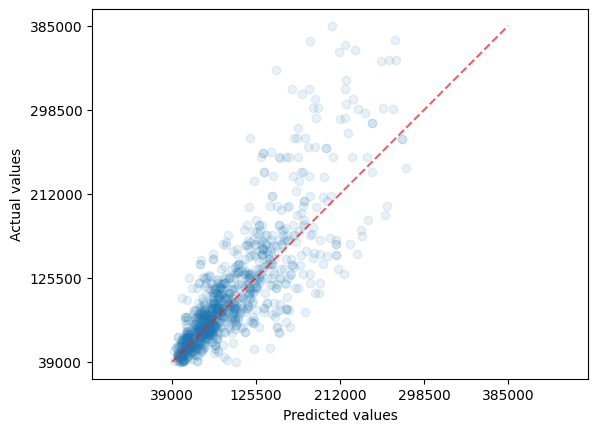

In [65]:
PredictionErrorDisplay.from_predictions(
        y_true=test_results.y_test,
        y_pred=test_results.y_test_pred,
        kind="actual_vs_predicted",
        scatter_kwargs={"alpha": 0.1, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )

In [95]:
#### Test Metrics #####
print('RMSE: {0:2f}'.format(np.sqrt(mean_squared_error(test_results.y_test,  test_results.y_test_pred))))
print('MAPE: {0:2f}'.format(mean_absolute_percentage_error(test_results.y_test,  test_results.y_test_pred)))
print('MSLE: {0:2f}'.format(mean_squared_log_error(test_results.y_test,  test_results.y_test_pred)))

RMSE: 36110.579383
MAPE: 0.190342
MSLE: 0.066226


# Conclusion